In [1]:
#agrewal2@wisc.edu
#mgdegrave@wisc.edu

# Project1 

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time

## Part 1 Prediction with Hardcoded Model

In [3]:
#reading data files
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

# turns df into numpy
nptrain = train.values
nptest = test.values 

traintorch = torch.tensor(nptrain, dtype = torch.float64) # Converts from np to tensor
testtorch = torch.tensor(nptest, dtype = torch.float64)

#using GPU if availible
if torch.cuda.is_available():
    traintorch = traintorch.to("cuda")
    testtorch = testtorch.to("cuda")

In [4]:
# splits into X and Y for our sets
trainX = traintorch[:, 0:10] 
trainY = traintorch[:, 10:11]

testX = testtorch[:, 0:10]
testY = testtorch[:, 10:11]



In [5]:
#coef
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX.dtype)

if torch.cuda.is_available():
    trainX = trainX.to("cuda")
    trainY = trainY.to("cuda")
    testX = testX.to("cuda")
    testY = testY.to("cuda")
    coef = coef.to("cuda")
    

#checking shapes of coef and textX for matrix multiplication
print(coef.shape)
print(testX.shape)

torch.Size([10, 1])
torch.Size([348, 10])


In [6]:
#predicting  the number of deaths for the first 
pred_deaths_row0test = testX[0] @ coef
print("predicted deaths for first row of test:", pred_deaths_row0test.item())

predicted deaths for first row of test: 9.844


In [7]:
#seeing difference
print("difference in predicted deaths and actual deaths for first row of test: ", f'{(pred_deaths_row0test - testY[0]).item():.3}')

difference in predicted deaths and actual deaths for first row of test:  0.844


## Part2: R^2 Score

In [8]:
#predicting values of y from testX
predictedY = testX @ coef

#function to calculate R^2 given predicted and true values of Y
def r2_score(trueY, predictedY):
    trueMean = torch.mean(testY, 0)
    SStot = torch.sum((trueY - trueMean)**2)
    SSreg = torch.sum((trueY - predictedY)**2)
    improvement = SStot - SSreg
    r_sq = improvement/SStot
    return r_sq

In [9]:
#getting R^2 for our hardcoded model
print("R^2:", f'{r2_score(testY, predictedY).item():.3}')

R^2: 0.411


## Part 3: Optimization

In [10]:
#y = x^2 - 8x + 1: we are optimizing this 
x = torch.tensor(0.0)
y = x**2 - 8*x + 19
y

tensor(19.)

In [11]:
#function we are optimizing
def f(x):
    return x**2 - 8*x + 19


x = torch.tensor(0.0, requires_grad = True)
optimizer = torch.optim.SGD([x], lr = 0.1)

for epoch in range(30):
    optimizer.zero_grad()
    y = f(x)
    y.backward()
    optimizer.step()
    print(x, y)

tensor(0.8000, requires_grad=True) tensor(19., grad_fn=<AddBackward0>)
tensor(1.4400, requires_grad=True) tensor(13.2400, grad_fn=<AddBackward0>)
tensor(1.9520, requires_grad=True) tensor(9.5536, grad_fn=<AddBackward0>)
tensor(2.3616, requires_grad=True) tensor(7.1943, grad_fn=<AddBackward0>)
tensor(2.6893, requires_grad=True) tensor(5.6844, grad_fn=<AddBackward0>)
tensor(2.9514, requires_grad=True) tensor(4.7180, grad_fn=<AddBackward0>)
tensor(3.1611, requires_grad=True) tensor(4.0995, grad_fn=<AddBackward0>)
tensor(3.3289, requires_grad=True) tensor(3.7037, grad_fn=<AddBackward0>)
tensor(3.4631, requires_grad=True) tensor(3.4504, grad_fn=<AddBackward0>)
tensor(3.5705, requires_grad=True) tensor(3.2882, grad_fn=<AddBackward0>)
tensor(3.6564, requires_grad=True) tensor(3.1845, grad_fn=<AddBackward0>)
tensor(3.7251, requires_grad=True) tensor(3.1181, grad_fn=<AddBackward0>)
tensor(3.7801, requires_grad=True) tensor(3.0756, grad_fn=<AddBackward0>)
tensor(3.8241, requires_grad=True) tenso

In [12]:
#optimized value of x
opt_x = x.item()
opt_x

3.9950480461120605

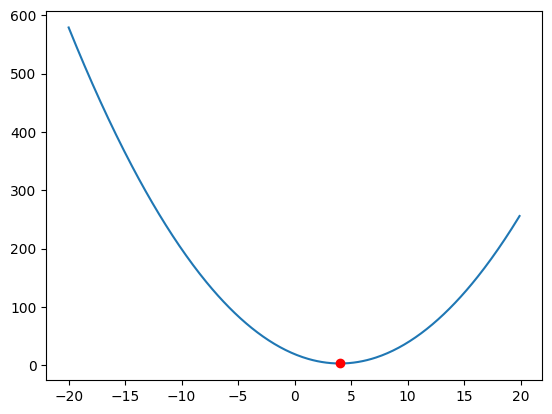

In [13]:
x_p = torch.arange(-20, 20, 0.1)
y_p = f(x_p)
plt.plot(x_p, y_p)
plt.plot(opt_x, f(opt_x), "ro")

from the above plot it out optimized x value we found by running the 30 epochs seems right because it seems to be at the local minima 
of the function y = y = x^2 - 8x + 1 that we are trying to minimize

## Part 4: Linear Regression

In [24]:
#making dataset object
ds = torch.utils.data.TensorDataset(trainX, trainY)
ds

In [25]:
#checking first row of ds
ds[0]

(tensor([24., 51., 44., 51., 60., 75., 72., 61., 27.,  0.], dtype=torch.float64),
 tensor([3.], dtype=torch.float64))

In [330]:
#important params
batches = 10
epochs = 220
in_features = trainX.shape[1]
out_features = trainY.shape[1]
learning_rate = 0.000001 - 0.00000085

In [331]:
#making data loader object
dl = torch.utils.data.DataLoader(ds, shuffle =True, batch_size= 10)
dl

In [332]:
model = torch.nn.Linear(in_features, out_features, dtype = torch.float64)
optimizer = torch.optim.SGD([model.weight, model.bias], lr = learning_rate)
loss_fn = torch.nn.MSELoss() #loss function
loss_list = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.9)

start = time.time()
#beginning of training loop:
for epoch in range(epochs):
    for batchx, batchy in dl:
        optimizer.zero_grad()
        predictedy = model(batchx)
        loss = loss_fn(batchy, predictedy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    x, y = ds[:]
    loss_list.append(loss_fn(y, model(x)).item())
    print("epoch:", epoch, "loss:", loss_fn(y, model(x)).item())
#end of training loop
end = time.time()

epoch: 0 loss: 365.628665404285
epoch: 1 loss: 328.27754320731486
epoch: 2 loss: 306.12851832580947
epoch: 3 loss: 289.8442835201787
epoch: 4 loss: 274.5027477135759
epoch: 5 loss: 261.3907673547803
epoch: 6 loss: 251.69983744427208
epoch: 7 loss: 237.39872617966225
epoch: 8 loss: 228.8329347454865
epoch: 9 loss: 218.18408357962315
epoch: 10 loss: 207.76858032616622
epoch: 11 loss: 199.05741759098345
epoch: 12 loss: 191.4347739821212
epoch: 13 loss: 183.1399347315296
epoch: 14 loss: 176.1940633661836
epoch: 15 loss: 168.38594686882018
epoch: 16 loss: 161.83538222895984
epoch: 17 loss: 155.80224163002444
epoch: 18 loss: 149.65873112729938
epoch: 19 loss: 144.36666159173745
epoch: 20 loss: 138.37295691530448
epoch: 21 loss: 133.52669006223704
epoch: 22 loss: 128.5103991081776
epoch: 23 loss: 124.71874726132197
epoch: 24 loss: 119.95470292887227
epoch: 25 loss: 115.73462015006645
epoch: 26 loss: 113.24295724230096
epoch: 27 loss: 107.83399043417396
epoch: 28 loss: 104.36877140492157
epoch

Text(0, 0.5, 'loss')

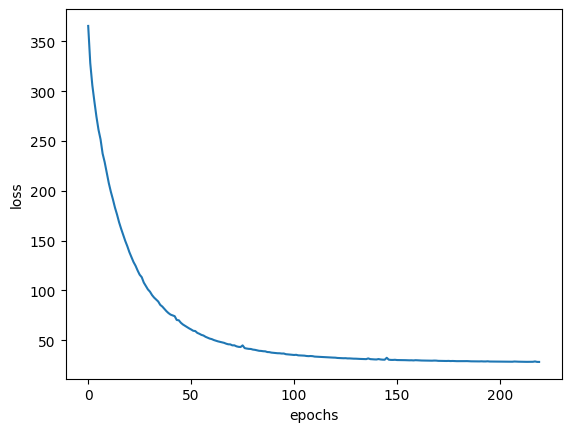

In [333]:
plt.plot([i for i in range(epoch+1)], loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [334]:
#time to train
train_time = end - start
print("time to train:", f'{train_time:0.4}', "secs")

time to train: 8.801 secs


In [335]:
#testing the model
testypred = model(testX)
testypred[0:5]

tensor([[ 9.7767],
        [18.9613],
        [ 3.0685],
        [ 2.4370],
        [ 8.6131]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [336]:
#computing R^2 for trained model
print("R^2 for trained model:", f'{r2_score(testY, testypred).item():.3}')

R^2 for trained model: 0.558


Text(0.5, 1.0, 'weights of each feature')

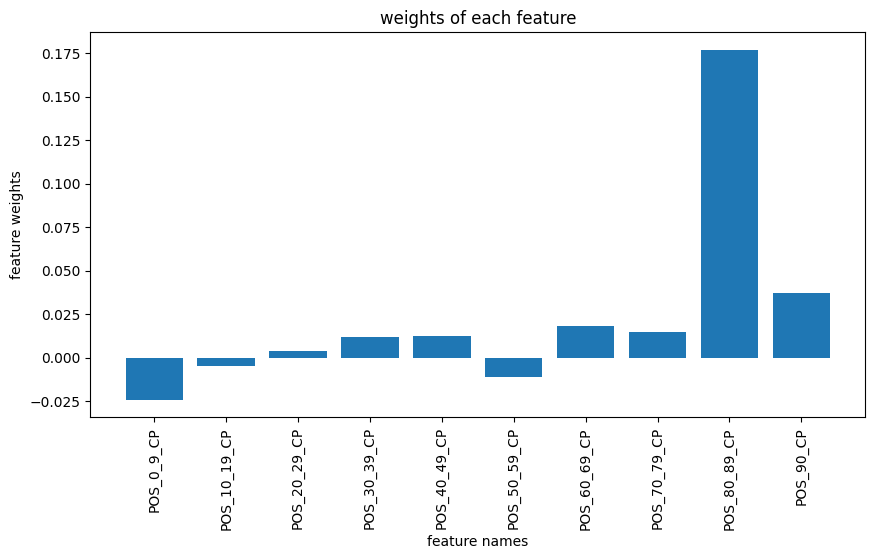

In [337]:
#getting feature names
feature_names = list(train.columns)[0:-1]
weights = model.weight.detach().numpy()
weights = weights.tolist()[0]

fig = plt.figure(figsize = (10, 5))
plt.bar(feature_names, weights, width = 0.8)
plt.xticks(rotation=90)
plt.xlabel("feature names")
plt.ylabel("feature weights")
plt.title("weights of each feature")

In [354]:
#checking how good our model is compared to scikits linear regression just for fun not meant for grade
from sklearn.linear_model import LinearRegression

In [355]:
#linear model
start = time.time()
reg = LinearRegression().fit(trainX, trainY)
print("R^2 score of scikits simple linear regression model: " f'{reg.score(testX, testY):0.3}')
end = time.time()

R^2 score of scikits simple linear regression model: 0.588


The R^2 we are getting seems pretty close to scikits, but our model takes more time to fit. I think we will see benefits of tensors and Gradient Descent for model training when we have much bigger data and GPU's to process it.